In [418]:
import numpy as np
import os
from os.path import join, isdir
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and proprocess documents
**Load document labels**

In [253]:
segmented_path = u'./corpus/segmented-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(segmented_path) if isdir(join(segmented_path, fn))] # list only folders
doc_labels_idx = {}
n_labels = len(doc_labels)
for i, label in enumerate(doc_labels):
    print i, label
    doc_labels_idx[label] = i
print 'Total Labels:', n_labels

0 บริหารธุรกิจ
1 ประมง
2 มนุษยศาสตร์
3 วนศาสตร์
4 วิทยาศาสตร์
5 วิทยาศาสตร์การกีฬา
6 วิศวกรรมศาสตร์
7 วิศวกรรมศาสตร์ กำแพงแสน
8 ศิลปศาสตร์และวิทยาศาสตร์
9 ศึกษาศาสตร์
10 สถาปัตยกรรมศาสตร์
11 สังคมศาสตร์
12 สัตวแพทยศาสตร์
13 สิ่งแวดล้อม
14 อุตสาหกรรมเกษตร
15 เกษตร
16 เกษตร กำแพงแสน
17 เศรษฐศาสตร์
18 เศรษฐศาสตร์ ศรีราชา
19 โครงการสหวิทยาการระดับบัณฑิตศึกษา
Total Labels: 20


** Load dataset **

In [135]:
%%time
dataset_contents, dataset_labels = [], []
for i, label in enumerate(doc_labels):
    curr_dir = join(segmented_path, label)
    fns = os.listdir(curr_dir)
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            dataset_contents.append(content)
            dataset_labels.append(i)
N = len(dataset_contents)
print 'Total Segmented Documents:', N

Total Segmented Documents: 775
Wall time: 12.6 s


** Define a function that trims words and replace all PIPELINE by space **

In [136]:
def pretty_trim(text):
    words = text.split('|')
    stripped_words_generator = (word.strip() for word in words) # generates a stripped word when its next() method is called
    trimmed_words = [word for word in stripped_words_generator if word] # retains words that are not empty
    return ' '.join(trimmed_words)

**Show sample content**

In [137]:
print 'Content:', dataset_contents[1][:2**8], '...'
print 'Label:', dataset_labels[1]

Content: I|50731470|I|0|b| |บท|ที่| |1|I|1|b| |ความ|สาคัญ|ของ|ปัญหา|P|จาก|วิกฤต|เศรษฐกิจ|ใน|ปี| |2550| |ประเทศสหรัฐอเมริกา|ได้|ประสบปัญหา|วิกฤต|เศรษฐกิจ|ที่|มี|P|จุด|กา|เนิด|จาก|หนี้เสีย|ของ|สินเชื่อ|บ้าน|ที่|ปล่อย|กู้|แก่|ผู้|มี|เครดิต|ต่ำกว่า|มาตรฐาน|และ|เกิด|ปัญ ...
Label: 0


** Show sample content after pretty_trimmed() **

In [138]:
print 'Content:', pretty_trim(dataset_contents[1][:2**8]), '...'
print 'Label Str:', doc_labels[dataset_labels[1]]

Content: I 50731470 I 0 b บท ที่ 1 I 1 b ความ สาคัญ ของ ปัญหา P จาก วิกฤต เศรษฐกิจ ใน ปี 2550 ประเทศสหรัฐอเมริกา ได้ ประสบปัญหา วิกฤต เศรษฐกิจ ที่ มี P จุด กา เนิด จาก หนี้เสีย ของ สินเชื่อ บ้าน ที่ ปล่อย กู้ แก่ ผู้ มี เครดิต ต่ำกว่า มาตรฐาน และ เกิด ปัญ ...
Label Str: บริหารธุรกิจ


** Trim all documents **

In [139]:
%%time
dataset_contents_trimmed = [pretty_trim(content) for content in dataset_contents]

Wall time: 12.2 s


** Count number of words for each document **

In [142]:
%time dataset_words_count = np.array([len(content.split()) for content in dataset_contents_trimmed])
print 'Words Count Mean: ', np.mean(dataset_words_count)
dataset_words_count[:min(40,N)]

Wall time: 3.34 s
Words Count Mean:  40804.4154839


array([ 41235,  24706,  41920,  39107,  43159,  53636,  32753,  46280,
        36777,  48854,  33029,  31878,  51160,  63060,  31636,  63538,
        16844,  17461,  33434,  30484,  19858,  92392,  51363,  55388,
        26136,  46479, 196975,  36790,  58717,  67169,  49065,  20123,
        20198,  39262,  42075,  31650,  24313,  17898,  26907,  22453])

** Show words count histogram **

<IPython.core.display.Javascript object>


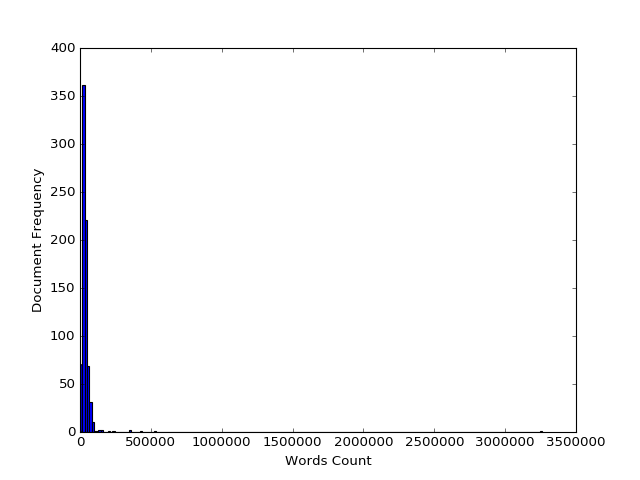

In [147]:
plt.figure()
plt.hist(dataset_words_count, bins=200)
plt.xlabel('Words Count')
plt.ylabel('Document Frequency')
plt.show()

# Machine Learning section

In [357]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from collections import Counter

## Train/Test Split
Split dataset into 2 parts and leave the test part untouched (not fitting it with any model)

Split using stratified sampling might be useful if you want to test all label including the skewed low frequency label

In [368]:
X_train, X_test, y_train, y_test = train_test_split(dataset_contents_trimmed, dataset_labels,
                                                    test_size=0.2, stratify=dataset_labels, random_state=42)
print 'Train Size:', len(X_train)
print 'Test Size:', len(X_test)
train_counter, test_counter = Counter(y_train), Counter(y_test)
print 'Un-trained label:', list(set(xrange(n_labels)) - set(train_counter))
print 'Un-tested label:', list(set(xrange(n_labels)) - set(test_counter))

Train Size: 618
Test Size: 157
Un-trained label: []
Un-tested label: []


### Plot bar chart of dataset frequency per label

<IPython.core.display.Javascript object>


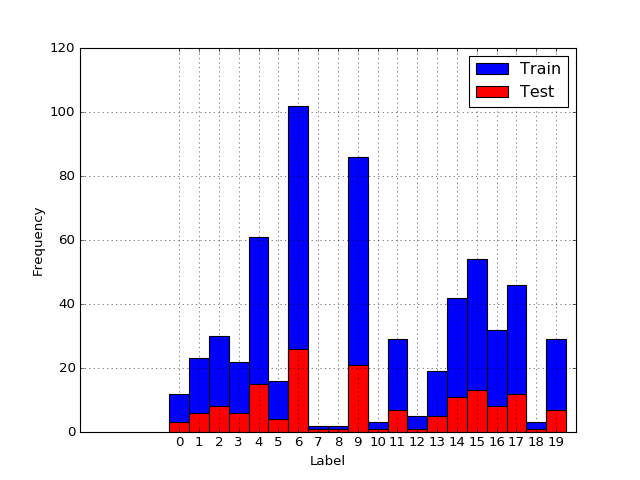

In [369]:
train_label_freqs = np.zeros(n_labels, np.int32)
test_label_freqs = np.zeros(n_labels, np.int32)
for k,v in train_counter.iteritems():
    train_label_freqs[k] = v
for k,v in test_counter.iteritems():
    test_label_freqs[k] = v
plt.figure()
plt.bar(np.arange(n_labels)-0.5, train_label_freqs, 1)
plt.bar(np.arange(n_labels)-0.5, test_label_freqs, 1, color='r')
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

## Feature Extraction
### Bag of Words Representation
Initialize a vectorizer that counts word instances and apply Tfidf (Term-Frequency * Inverse-Document-Frequency) to them

In [370]:
%%time
tfidf = TfidfVectorizer(encoding=u'utf-8', stop_words='english', binary=False, max_features=None)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

Wall time: 46.5 s


** Save extracted feature names to disk **

In [371]:
%%time
feature_names = tfidf.get_feature_names()
fn = 'feature_names.txt'
with open(fn, 'w') as f:
    f.write(u'\n'.join(feature_names).encode('utf8'))
print 'Check file %s to see all extracted feature names' % fn
print 'Total names:', len(feature_names)

Check file feature_names.txt to see all extracted feature names
Total names: 480826
Wall time: 1.91 s


**Vectorized Dataset Statistics**

In [419]:
print 'Train Shape:', X_train_vectorized.shape
print 'Sample content of type %s:' % type(X_train_vectorized)
print X_train_vectorized

Train Shape: (618, 480826)
Sample content of type <class 'scipy.sparse.csr.csr_matrix'>:
  (0, 278129)	0.000493902002621
  (0, 463644)	0.000172457326762
  (0, 393171)	0.000269185279192
  (0, 473492)	0.000582523654997
  (0, 464106)	0.000177183221348
  (0, 466332)	0.000195206003737
  (0, 471555)	0.000238054199017
  (0, 468866)	0.000209783232853
  (0, 461210)	0.000247463379277
  (0, 470733)	0.000270402184015
  (0, 466070)	0.000196942155563
  (0, 472391)	0.000730257662238
  (0, 463439)	0.000237101841357
  (0, 140723)	0.000294486067374
  (0, 467096)	0.000264427301415
  (0, 467298)	0.000189468966337
  (0, 310342)	0.000885140398799
  (0, 230522)	0.000459497789369
  (0, 106211)	0.00051670937197
  (0, 186381)	0.000564155472193
  (0, 66698)	0.000459497789369
  (0, 182378)	0.000687467354869
  (0, 179897)	0.000620332208644
  (0, 178976)	0.000649658801222
  (0, 141942)	0.000553197062418
  :	:
  (617, 464591)	0.00280864337312
  (617, 470899)	0.00213167230638
  (617, 467301)	0.00138138452715
  (617, 

## Feature Selection

Recursive feature elimination using weights of Linear Kernel Support Vector Machine

In [399]:
%%time
rfe = RFE(SGDClassifier(loss='hinge'), n_features_to_select=20000, step=0.10)
X_train_selected = rfe.fit_transform(X_train_vectorized, y_train)
X_test_selected = rfe.transform(X_test_vectorized)
print X_train_selected.shape, X_test_selected.shape

(618, 20000) (157, 20000)
Wall time: 8.24 s


** Save top feature names to file **

In [400]:
%%time
top_features = [feature for feature, support in zip(feature_names, rfe.support_) if support]
file_name = 'feature_names_top.txt'
with open(file_name, 'w') as f:
    f.write(u'\n'.join(top_features).encode('utf8'))
print 'Go check file %s' % file_name

Go check file feature_names_top.txt
Wall time: 285 ms


## Dimensionality Reduction

Truncated SVD (Single Value Decomposition) is called Latent Semantic Analysis (LSA) in text analysis context

In [345]:
# %%time
# svd = TruncatedSVD(n_components=200) # works on sparse data
# X_train_reduced = svd.fit_transform(X_train_selected)
# X_test_reduced = svd.transform(X_test_selected)
# print 'Train Shape:', X_train_reduced.shape
# print 'Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum()
# print 'Top 5 Explained Variance Ratio:', svd.explained_variance_ratio_[:5]

Train Shape: (620L, 200L)
Explained Variance Ratio Sum: 0.680931519226
Top 5 Explained Variance Ratio: [ 0.08757407  0.0295904   0.01745794  0.01065465  0.01066833]
Wall time: 1.93 s


## Training models

In [401]:
%%time
models = [LogisticRegression(), LinearSVC(), DecisionTreeClassifier(max_depth=15),
          SGDClassifier(), KNeighborsClassifier(n_neighbors=2), Perceptron(), RandomForestClassifier()]
for clf in models:
    print 'Training', type(clf).__name__
    %time clf.fit(X_train_selected, y_train)

Training LogisticRegression
Wall time: 2.76 s
Training LinearSVC
Wall time: 1.49 s
Training DecisionTreeClassifier
Wall time: 1.91 s
Training SGDClassifier
Wall time: 215 ms
Training KNeighborsClassifier
Wall time: 12 ms
Training Perceptron
Wall time: 249 ms
Training RandomForestClassifier
Wall time: 304 ms
Wall time: 6.95 s


## Models Scoring
Evaluate on both train and test set

In [420]:
for clf in models:
    print type(clf).__name__
    for X,y,t in [(X_train_selected, y_train, 'Train'), (X_test_selected, y_test, 'Test')]:
        pred = clf.predict(X) # change to reduced or selected for 2 ways of reducing dimensions
        print t, 'dataset'
        print 'Accuracy Score:', accuracy_score(y, pred)
        print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print

LogisticRegression
Train dataset
Accuracy Score: 0.736245954693
Precision Recall F-Score:
(0.73928676627654533, 0.7362459546925566, 0.68808250554148509, None)
Test dataset
Accuracy Score: 0.515923566879
Precision Recall F-Score:
(0.50865580841357549, 0.51592356687898089, 0.45184678309792675, None)

LinearSVC
Train dataset
Accuracy Score: 0.993527508091
Precision Recall F-Score:
(0.99372556665250866, 0.99352750809061485, 0.99332303756254225, None)
Test dataset
Accuracy Score: 0.668789808917
Precision Recall F-Score:
(0.62939340670897936, 0.66878980891719741, 0.63580669518670496, None)

DecisionTreeClassifier
Train dataset
Accuracy Score: 0.961165048544
Precision Recall F-Score:
(0.95879278410537305, 0.96116504854368934, 0.95916171720584598, None)
Test dataset
Accuracy Score: 0.605095541401
Precision Recall F-Score:
(0.61209559195227969, 0.60509554140127386, 0.60142259764390149, None)

SGDClassifier
Train dataset
Accuracy Score: 0.996763754045
Precision Recall F-Score:
(0.996837305089732

## Train a Model with Cross-Validation Set
**Support Vector Machine implemented using Stochastic Gradient Descent**

Tune the model's hyper-parameters to give high 3-Fold CV score

In [409]:
%%time
params = {'alpha':[1e-4, 1e-3, 1e-5], 'n_iter':[100, 200]}
gs = GridSearchCV(SGDClassifier(random_state=42), params, scoring='f1_weighted', cv=3)
gs.fit(X_train_selected, y_train)

Wall time: 1min 23s


In [411]:
print gs.best_estimator_
print gs.best_params_
print gs.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
{'alpha': 0.0001, 'n_iter': 200}
0.629706329672


In [422]:
clf = gs.best_estimator_
print type(clf).__name__
for X,y,t in [(X_train_selected, y_train, 'Train'), (X_test_selected, y_test, 'Test')]:
    pred = clf.predict(X) # change to reduced or selected for 2 ways of reducing dimensions
    print '=>', t, 'dataset'
    print 'Accuracy Score:', accuracy_score(y, pred)
    print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print
print 'Baseline score by chance:', 1.0 / n_labels, '(assume that an algorithm randomly guesses the label)'

SGDClassifier
=> Train dataset
Accuracy Score: 1.0
Precision Recall F-Score:
(1.0, 1.0, 1.0, None)

=> Test dataset
Accuracy Score: 0.68152866242
Precision Recall F-Score:
(0.6526088585531139, 0.68152866242038213, 0.65684415874660596, None)

Baseline score by chance: 0.05 (assume that an algorithm randomly guesses the label)


## Model Evaluation Metrics

### Confusion Matrix

In [424]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(n_labels)
    plt.xticks(tick_marks, doc_labels, rotation=45)
    plt.yticks(tick_marks, doc_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')